This notebook contains 2-layer CNN model with a record for hyperparameter tuning and first layer filter visualization.

Yuxi Ke, Nov. 19, 2020

In [19]:
import data_loader
import numpy as np
import os
import tensorflow as tf
import math
import timeit
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
%load_ext autoreload
%autoreload 2
import erreval
import plots
import updated_plots

plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ALPHABET = 'GALMFWKQESPVICYHRNDT'

def onehot_encode(aaseq: str):
    """
    Convert AA sequence to onehot encoding numpy array.
    Args:
        aaseq - str
    Returns:
        onehotarr - (lenseq, 20) np.array
    """
    alphabet = 'GALMFWKQESPVICYHRNDT'
    aa2int = {k: i for i,k in enumerate(alphabet)}
    #int2aa = {i: k for i,k in enumerate(alphabet)}

    lenseq = len(aaseq)
    onehotarr = np.zeros((lenseq, 20), dtype=int)
    for i,aa in enumerate(aaseq):
        onehotarr[i, aa2int[aa]] = 1

    return onehotarr

In [3]:
oh = lambda x: onehot_encode(x["Extended Domain sequence"])
# test = onehot_encode(nucrepr_data.loc[1,"Extended Domain sequence"])

nucrepr_data = pd.read_csv("./data/NucRepr_data.csv")
nucrepr_data["one_hot_encoding"] = nucrepr_data["Extended Domain sequence"].apply(onehot_encode)

loader = data_loader.DataLoader("UniRep1900_BareNucRepr.csv")
id_train, id_val, id_test = loader.getIdx()
n_seq = 80
n_AA = 20
n_train = len(id_train)
n_val = len(id_val)
n_test = len(id_test)
_, (y_train, y_val, y_test) = loader.loadTrainValTest()

In [4]:
nuc_csv = pd.read_csv("UniRep1900_BareNucRepr.csv")
nuc_csv["one_hot_encoding"] = nuc_csv["Extended Domain sequence"].apply(onehot_encode)

x_train = np.zeros((n_train,1, n_seq, n_AA))
for i in range(n_train):
    x_train[i,0,:,:] = nuc_csv.loc[id_train[i],"one_hot_encoding"]
    
x_val = np.zeros((n_val,1, n_seq, n_AA))
for i in range(n_val):
    x_val[i,0,:,:] = nuc_csv.loc[id_val[i],"one_hot_encoding"]

x_test = np.zeros((n_test,1, n_seq, n_AA))
for i in range(n_test):
    x_test[i,0,:,:] = nuc_csv.loc[id_test[i],"one_hot_encoding"]


print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(2792, 1, 80, 20)
(262, 1, 80, 20)
(239, 1, 80, 20)


In [5]:
train_ind, val_ind, test_ind = loader.getIdx()

nucrepr = pd.read_csv(r'../data/NucRepr.csv')
clean = nucrepr[['Extended Domain sequence', 'Extended Domain DNA sequence', 'Well-expressed', 'Hit', 'Avg Stbl', 'R1 ReprD5', 'R2 ReprD5', 'Avg ReprD5', 'Avg ReprD9', 'Avg ReprD13']]

train_ind, val_ind, test_ind = loader.getIdx()

train_rep = clean.loc[clean['Well-expressed']].iloc[train_ind].loc[:, ['R1 ReprD5', 'R2 ReprD5']]
val_rep = clean.loc[clean['Well-expressed']].iloc[val_ind].loc[:, ['R1 ReprD5', 'R2 ReprD5']]

### Conv model

In [6]:
record = pd.DataFrame(columns = ['NumConvLayer', 'NumFilter', 'DropOut', 'Patience', 'LR', 'FilterSize', 'TrainMSE', 'ValMSE', 'TrainMAE', 'ValMAE', 'TrainZScore', 'ValZScore'])
record = record.astype({'Patience': int})

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 80, 40)         32040     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 80, 24)         38424     
_________________________________________________________________
dropout (Dropout)            (None, 1, 80, 24)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 40, 24)         0         
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 961       
Total params: 71,425
Trainable params: 71,425
Non-trainable params: 0
____________________________________________________

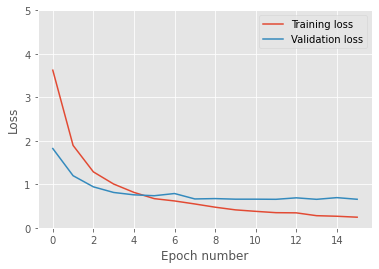

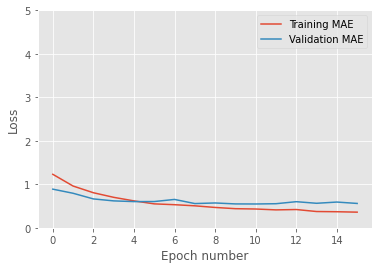

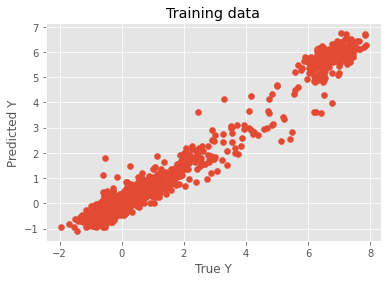

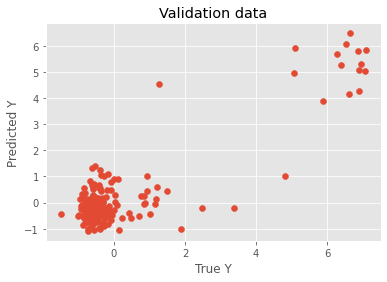

training zscore: 7.566356840305572
validation zscore: 4.952044657205236


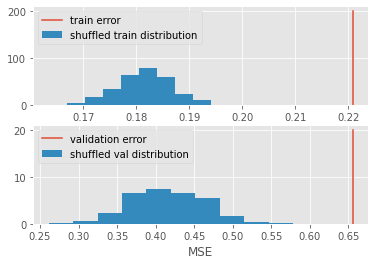

training mse 0.2208741477902139
validation mse 0.6559518000202493
training zscore: 5.798661512743205
validation zscore: 7.509003175805823


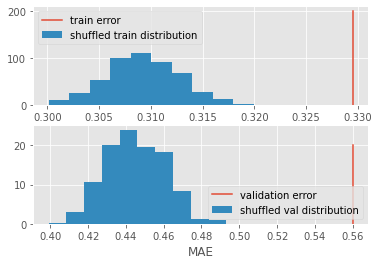

training mae 0.3295174747940803
validation mae 0.5601035131765182


In [7]:
# 2-layer
settings = {'NumConvLayer': 2, 'NumFilter': (40, 24), 'DropOut': 0.4, 'Patience': 2, 'LR': 5e-4, 'FilterSize': 40}
input_shape = (1, 80, 20)

initializer = tf.initializers.VarianceScaling(scale=2.0)
layers = [
    tf.keras.layers.Conv2D(settings['NumFilter'][0], (1,settings['FilterSize']), activation='relu', padding = 'same',
                                kernel_initializer=initializer, input_shape = input_shape),
    tf.keras.layers.Conv2D(settings['NumFilter'][1], (1,settings['FilterSize']), activation='relu', padding = 'same',
                                kernel_initializer=initializer, input_shape = input_shape),
    tf.keras.layers.Dropout(settings['DropOut']),
    tf.keras.layers.MaxPool2D(pool_size = (1,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, kernel_initializer=initializer),
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(
  monitor='val_mean_squared_error', min_delta=0.0001, patience=settings['Patience'])

model = tf.keras.Sequential(layers)
print(model.summary())

n_epochs = 100
val_losses = []
lr = settings['LR'] #learning_rates = [1e-3, 5e-4, 1e-5] #5e-5, 1e-4,  

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer,
            loss='mean_squared_error',
            metrics=["mean_squared_error", "mean_absolute_error"])
output = model.fit(x_train, y_train, 
                   batch_size=128, 
                   epochs=n_epochs, 
                   validation_data=(x_val, y_val),
                   callbacks=[earlystop_callback])

train_pred, val_pred = plots.plotProgress(x_train, y_train, x_val, y_val, output, model)
    
settings['TrainMSE'], settings['ValMSE'], settings['TrainZScore'], settings['ValZScore'] = \
    plots.doPermTest(train_rep, train_pred, val_rep, val_pred)
mae_result = \
    plots.doMAEPermTest(train_rep, train_pred, val_rep, val_pred)
settings['TrainMAE'] = mae_result[0]
settings['ValMAE'] = mae_result[1]
record = record.append(settings, ignore_index=True)

In [8]:
# Get the MAE on test set
model.evaluate(x_test, y_test)

8/8 [==============================] - 0s 2ms/step - loss: 0.8139 - mean_squared_error: 0.8139 - mean_absolute_error: 0.6151


[0.8139227628707886, 0.8139227628707886, 0.615115225315094]

In [9]:
record

,NumConvLayer,NumFilter,DropOut,Patience,LR,FilterSize,TrainMSE,ValMSE,TrainMAE,ValMAE,TrainZScore,ValZScore
0,2,"(40, 24)",0.4,2,0.0005,40,0.220874,0.655952,0.329517,0.560104,7.566357,4.952045


### Updated plots

In [10]:
out = output.history
val_mse = output.history.get("val_mean_squared_error")[-1]

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


<Figure size 576x432 with 0 Axes>

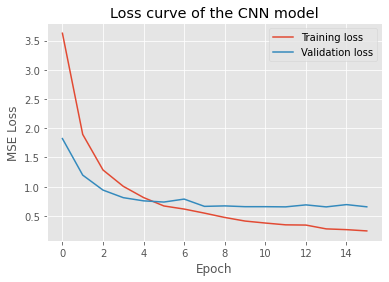

In [11]:
train_losses = out.get("mean_squared_error")
train_mae = out.get("mean_absolute_error")
print(out.keys()) # gives dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])
val_losses = out.get("val_mean_squared_error")
val_mae = out.get("val_mean_absolute_error")
updated_plots.plotTrainCurve({"Training loss": train_losses, 
                "Validation loss": val_losses}, 
                             y_label='MSE Loss', 
                             title= 'Loss curve of the CNN model', 
                             show_title=True, 
                             show=True, save=True)
plt.show()

<Figure size 864x864 with 0 Axes>

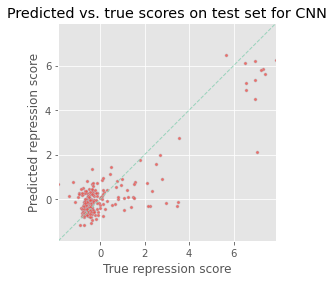

In [13]:
updated_plots.plotActualVsPred(y_true=y_test,
                 y_pred=model.predict(x_test),
                 title='Predicted vs. true scores on test set for CNN',
                 save=True)
plt.show()

<Figure size 864x864 with 0 Axes>

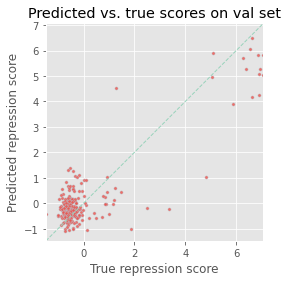

In [14]:
updated_plots.plotActualVsPred(y_true=y_val,
                 y_pred=model.predict(x_val),
                 title='Predicted vs. true scores on val set')
plt.show()

## 3. Visulaization

### Filters

Dependency: `logomaker`

In [15]:
import logomaker

from sklearn.manifold import TSNE
from sklearn import cluster

In [16]:
filters, biases = model.layers[0].get_weights()
print(filters.shape)
print(model.summary())

(1, 40, 20, 40)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 80, 40)         32040     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 80, 24)         38424     
_________________________________________________________________
dropout (Dropout)            (None, 1, 80, 24)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 40, 24)         0         
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 961       
Total params: 71,425
Trainable params: 71,425
Non-trainable params: 0
____________________________________

![color_scheme](https://logomaker.readthedocs.io/en/latest/_images/color_schemes.png)

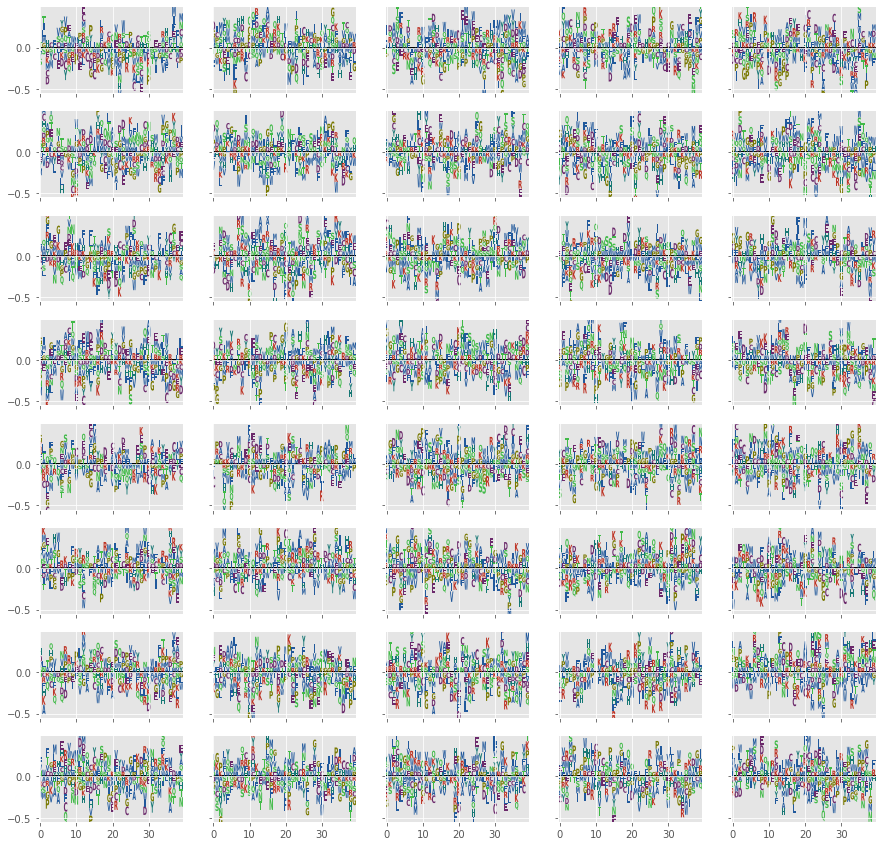

In [18]:
fig, ax = plt.subplots(8, 5, figsize=(15,15), sharex=True, sharey=True)
ax = ax.flatten()
std_cutoff = np.std(filters.flatten())
filters_cutoff = filters.squeeze().copy()
filters_cutoff[np.abs(filters_cutoff) < std_cutoff] = 0
for i in range(filters.shape[3]):
    filter_df = pd.DataFrame(data=filters_cutoff[:,:,i], columns = list(ALPHABET))
    filter_logo = logomaker.Logo(filter_df, color_scheme='NajafabadiEtAl2017', 
                                 baseline_width=2, flip_below=False, ax=ax[i])
    filter_logo.draw()
plt.savefig('Motifs from CNN.jpeg', transparent=True)
plt.show()

In [20]:
# tsne
filters_transformed = np.swapaxes(filters.squeeze(), 2, 0).reshape((40, -1))
tsne = TSNE(perplexity=7, early_exaggeration=100, learning_rate=10, metric='manhattan')
embed_motif = tsne.fit_transform(filters_transformed)

In [28]:
n_clusters = 6
filter_centroid, label, _ = cluster.k_means(filters_transformed, n_clusters=n_clusters)

(40, 2)


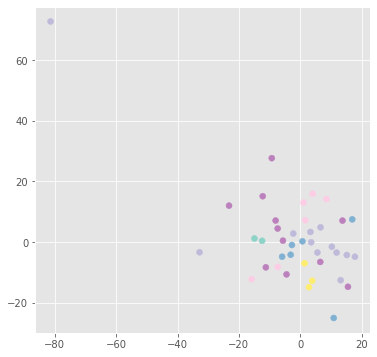

In [29]:
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(embed_motif[:,0], embed_motif[:,1], c=label, cmap='Set3')
print(embed_motif.shape)
plt.show()

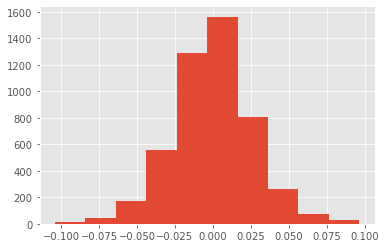

In [30]:
plt.hist(filter_centroid.flatten())
plt.show()

In [31]:
filter_centroid_cutoff = filter_centroid.copy()
std = np.std(filter_centroid)
print('std', std)
filter_centroid_cutoff[np.abs(filter_centroid) < std] = 0

std 0.026109194


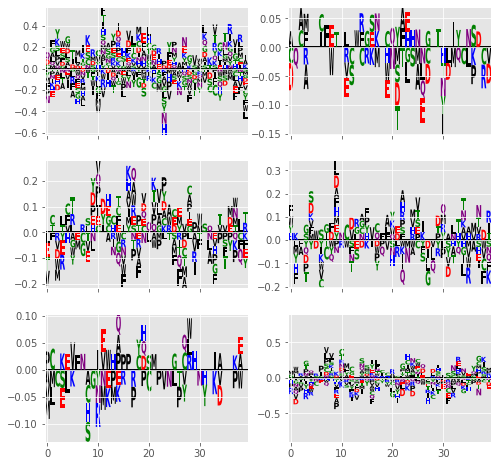

In [32]:
fig, ax = plt.subplots(3, 2, figsize=(8, 8), sharex=True)
ax = ax.flatten()
for i in range(n_clusters):
    filter_df = pd.DataFrame(data=filter_centroid_cutoff[i].T.reshape(40, 20), columns=list(ALPHABET))
    filter_logo = logomaker.Logo(filter_df, color_scheme='chemistry',#'NajafabadiEtAl2017', 
                                 baseline_width=2, flip_below=False, ax=ax[i])
    filter_logo.draw()

#     plt.xlabel('Position')
#     plt.ylabel('Weight')
plt.ylim([-0.9, +0.9])
plt.show()

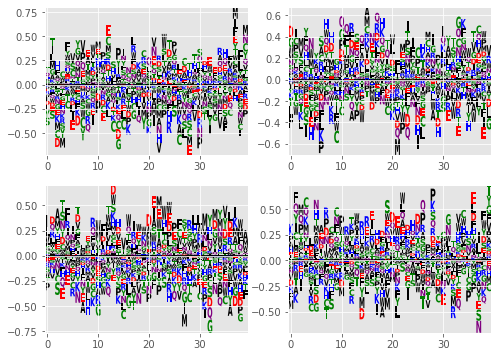

In [26]:
fig, ax = plt.subplots(2,2, figsize=(8,6))
ax = ax.flatten()
for i in range(4):
    filter_df = pd.DataFrame(data=filters[:, :, :, i].squeeze(), columns = list(ALPHABET))
    filter_logo = logomaker.Logo(filter_df, color_scheme='chemistry',#'NajafabadiEtAl2017', 
                                 baseline_width=2, flip_below=False, ax=ax[i])
    filter_logo.draw()
plt.show()